<a href="https://colab.research.google.com/github/akitim/SkillFactory_current/blob/main/Unit_7_ML_Text_Clustering_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кластеризация текстов

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Выбираем 4 категории новостей для легковесности примера
categories = [
    'rec.sport.hockey', # хоккей
    'talk.politics.mideast', # политические новости о Ближнем Востоке
    'comp.graphics', # компьютерная графика
    'sci.crypt' # криптография
]

# Скачиваем набор данных
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d документов" % len(dataset.data))
print("%d категории" % len(dataset.target_names))

# Записываем значения категорий для каждой новости
labels = dataset.target

3903 документов
4 категории


## Предобработка данных

In [3]:
# Исходный набор данных, первые 10 примеров
for i in range(10):
    print(dataset.data[i], end='\n' + '*' * 50 + '\n\n')

From: c5ff@jupiter.sun.csd.unb.ca (COOK  Charlie)
Subject: NHL Summary parse results for games played Mon, April 19, 1993
Organization: University of New Brunswick
Lines: 79

Toronto                          1 1 1--3
Detroit                          1 4 1--6
First period
     1, Detroit, Yzerman 1 (Gallant, Ciccarelli) 4:48.
     2, Toronto, Cullen 1 (Clark, Gill) 10:44.
Second period
     3, Detroit, Sheppard 1 (Probert, Coffey) pp, 5:04.
     4, Detroit, Burr 1 (Racine) sh, 6:42.
     5, Detroit, Chiasson 1 (Coffey) pp,11:00.
     6, Detroit, Howe 1 (Yzerman, Drake) 14:46.
     7, Toronto, Gilmour 1 (Borschevsky, Ellett) pp, 19:59.
Third period
     8, Detroit, Racine 1 (Primeau, Drake) 5:10.
     9, Toronto, Lefebvre 1 (Cullen, Pearson) 7:45.

Detroit: 6    Power play: 6-2   Special goals:  pp: 2  sh: 1  Total: 3
Scorer            G    A   Pts
---------------  ---  ---  ---
Burr               1    0    1
Chiasson           1    0    1
Ciccarelli         0    1    1
Coffey           

In [4]:
# Создаём объект, который будет токенизировать данные
analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Токенизируем наш набор данных
docs = []
for document in dataset.data:
    docs.append(analyzer(document.replace('_', '')))

# И посмотрим 10 первых примеров
for i in range(10):
    print(docs[i], end='\n\n')

['c5ff', 'jupiter', 'sun', 'csd', 'unb', 'ca', 'cook', 'charlie', 'subject', 'nhl', 'summary', 'parse', 'results', 'games', 'played', 'mon', 'april', '19', '1993', 'organization', 'university', 'new', 'brunswick', 'lines', '79', 'toronto', 'detroit', 'period', 'detroit', 'yzerman', 'gallant', 'ciccarelli', '48', 'toronto', 'cullen', 'clark', 'gill', '10', '44', 'second', 'period', 'detroit', 'sheppard', 'probert', 'coffey', 'pp', '04', 'detroit', 'burr', 'racine', 'sh', '42', 'detroit', 'chiasson', 'coffey', 'pp', '11', '00', 'detroit', 'howe', 'yzerman', 'drake', '14', '46', 'toronto', 'gilmour', 'borschevsky', 'ellett', 'pp', '19', '59', 'period', 'detroit', 'racine', 'primeau', 'drake', '10', 'toronto', 'lefebvre', 'cullen', 'pearson', '45', 'detroit', 'power', 'play', 'special', 'goals', 'pp', 'sh', 'total', 'scorer', 'pts', 'burr', 'chiasson', 'ciccarelli', 'coffey', 'drake', 'gallant', 'howe', 'primeau', 'probert', 'racine', 'sheppard', 'yzerman', 'toronto', 'power', 'play', 'sco

In [6]:
# Проверим, что число документов осталось прежним
len(docs)

3903

## Векторизация текстов

In [7]:
# Установка пакета gensim
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


При работе в Google Colab обязательно нужно запустить код из ячейки выше, несмотря на то, что в Google Colab gensim уже предустановлен. Так gensim обновится до последней версии.  
На данный момент в Google Colab уставнолена одна из прошлых версий модуля gensim, и поэтому на ней код ниже работать не будет.

In [8]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на нашем наборе данных
# На выходе мы получим вектор признаков для каждого слова
model = Word2Vec(docs, min_count=20, vector_size=50)

# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для наших документов
X = []
for doc in docs:
    X.append(doc_vectorizer(doc, model))

In [9]:
# Как выглядят первые 10 документов после векторизации 
X[:10]

[array([-1.6670473 ,  0.01875693,  0.7618899 ,  0.98693573, -0.13431022,
         0.02852537,  0.95014226,  0.7978939 , -0.7918357 , -0.17943892,
        -0.06239235, -0.7698878 , -0.3812103 ,  0.39583936,  0.13360377,
        -0.18068743, -0.41356707, -0.00239936, -0.07657936, -0.3990263 ,
        -0.32666045, -0.11157899,  1.0071096 , -0.742321  ,  0.2525405 ,
         0.53913695, -0.8035841 , -0.25309902, -0.08174463, -0.6641691 ,
        -0.04808415,  0.07345166,  0.18512912,  0.63880736, -1.2639667 ,
        -0.11120225, -0.26681828, -0.18008532,  0.5857498 , -0.8443326 ,
         0.577442  , -0.57045686, -0.56747574,  0.02619366,  0.4602706 ,
         0.31176832, -0.51383525, -0.93381613, -0.07114286, -0.19773589],
       dtype=float32),
 array([-1.297517  , -0.1990708 ,  0.30848765,  0.66490847, -0.28180152,
        -0.39344522,  0.72916555,  0.61806345, -0.59970075, -0.13698304,
        -0.3844425 , -0.7536215 , -0.40995732,  0.12566426, -0.34947258,
        -0.28680444,  0.093

In [10]:
# Проверим размер вектора для документа
print(np.asarray(X).shape)

(3903, 50)


In [11]:
# t-SNE – метод понижения размерности
from sklearn.manifold import TSNE

# Создаём объект для выполнения t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Преобразуем наши данные, понизив размерность с 50 до 2
X = tsne.fit_transform(X)

print(np.asarray(X).shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(3903, 2)


## Кластеризация

In [12]:
# Создаём KMeans кластеризатор 
kmeans = KMeans(n_clusters=4)

# Обучим кластеризатор на подготовленных данных
kmeans.fit(X)

KMeans(n_clusters=4)

In [13]:
# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(int)

# Координаты полученных центроидов
print ("Координаты центроидов:\n", kmeans.cluster_centers_)

Координаты центроидов:
 [[ 53.318794    -0.20015663]
 [-39.85047      1.8504602 ]
 [ -7.054946   -35.31473   ]
 [ -5.1436977   47.306705  ]]


In [14]:
# Метрики
print ("Коэффициент силуэта: %0.3f" % metrics.silhouette_score(X, y_pred, metric='euclidean'))
print("Однородность: %0.3f" % metrics.homogeneity_score(labels, y_pred))
print("Полнота: %0.3f" % metrics.completeness_score(labels, y_pred))
print("V-мера: %0.3f" % metrics.v_measure_score(labels, y_pred))

Коэффициент силуэта: 0.508
Однородность: 0.769
Полнота: 0.772
V-мера: 0.770


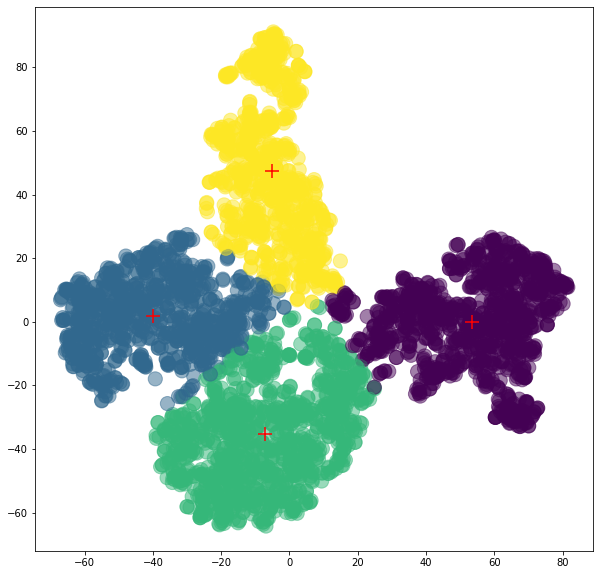

In [15]:
# Графики полученных кластеров
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

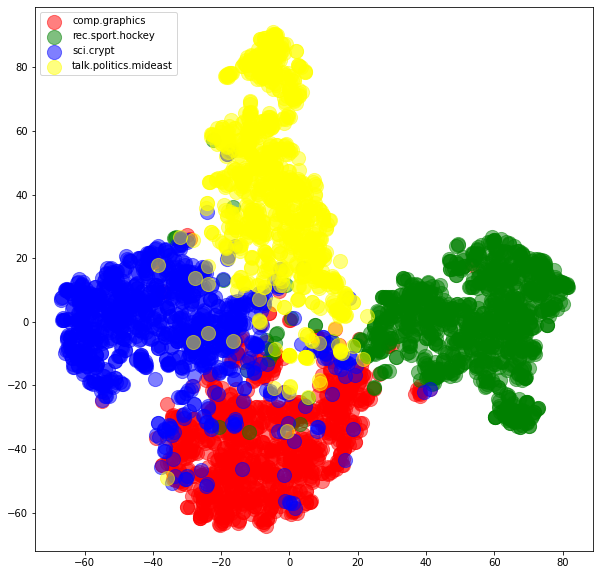

In [16]:
# Построим график истинных классов
colors = ("red", "green", "blue", "yellow")

for i in range(4):
    plt.scatter(X[labels==i][:, 0], X[labels==i][:, 1], \
                s=200, alpha=.5, c=colors[i], label=dataset.target_names[i])
    plt.legend(loc=2)

plt.show()